In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import japanize_matplotlib

In [2]:
train_df = pd.read_csv(r'C:\Users\Issei\Desktop\Class Documents\KEIO 2024 Fall\Data Science\Datasets\out\train_tokyo.csv', index_col=0)
test_df = pd.read_csv(r"C:\Users\Issei\Desktop\Class Documents\KEIO 2024 Fall\Data Science\Datasets\out\test_tokyo.csv", index_col=0)
answer_df = pd.read_csv(r"C:\Users\Issei\Desktop\Class Documents\KEIO 2024 Fall\Data Science\Datasets\out\answer_tokyo.csv")

In [3]:
train_df.drop('物件ID', axis=1, inplace=True)
train_df.drop('敷金', axis=1, inplace=True)
train_df.drop('礼金', axis=1, inplace=True)
test_df.drop('物件ID', axis=1, inplace=True)
test_df.drop('敷金', axis=1, inplace=True)
test_df.drop('礼金', axis=1, inplace=True)

Text(0.5, 1.0, 'トレーニングデータの賃料/価格の箱ひげ図')

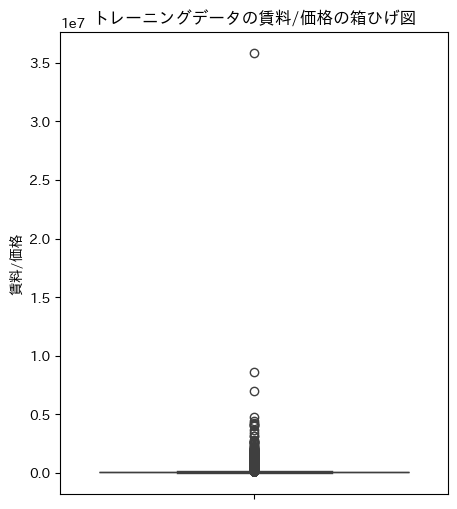

In [4]:
# visualize outliers in train_df
plt.figure(figsize=(5, 6))
sns.boxplot(y='賃料/価格', data=train_df)
plt.title('トレーニングデータの賃料/価格の箱ひげ図')

In [5]:
# remove outliers
train_df = train_df[train_df['賃料/価格'] < 0.55*1e7]

Text(0.5, 1.0, 'トレーニングデータの賃料/価格の箱ひげ図')

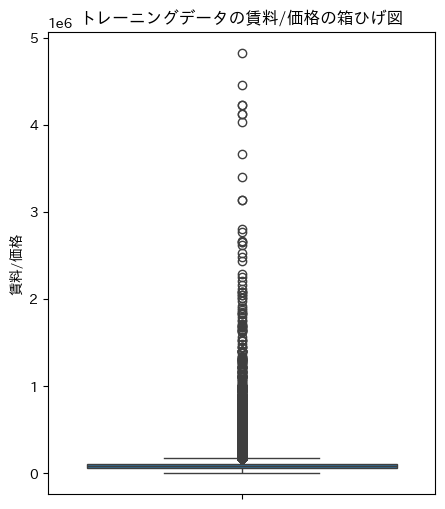

In [6]:
# visualize outliers in train_df
plt.figure(figsize=(5, 6))
sns.boxplot(y='賃料/価格', data=train_df)
plt.title('トレーニングデータの賃料/価格の箱ひげ図')

In [7]:
from sklearn.model_selection import train_test_split
X = train_df.drop('賃料/価格', axis=1)
y = train_df['賃料/価格']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [10]:
# Do hypeparameter tuning with XGBoost using optuna and no outliers
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
import optuna



def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.40, 0.41),
        'lambda': trial.suggest_float('lambda', 0.73, 0.76),
        'learning_rate': trial.suggest_float('learning_rate', 0.017, 0.018),
        'max_depth': 13,
        'min_child_weight': 1,
        'alpha': trial.suggest_float('alpha', 0.5, 0.53),
        'gamma': trial.suggest_float('gamma', 0.62, 0.64),
        'subsample': trial.suggest_float('subsample', 0.97, 0.98),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.45, 0.46),
        'seed': 123
    }
    
    # Convert the data to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Train the model with `num_boost_round`
    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=trial.suggest_int('num_boost_round', 395, 405),
        evals=[(dtest, 'validation')],
        early_stopping_rounds=5,
        verbose_eval=False
    )
    
    # Predict and calculate RMSE
    preds = bst.predict(dtest)
    score = np.sqrt(mean_squared_error(y_test, preds))
    return score

# Create and optimize the study
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=10, n_jobs=-1)

print(study.best_params, study.best_value)

[I 2025-01-15 17:41:31,261] A new study created in memory with name: no-name-a3881250-7fff-44e8-a274-ca7bcfd29fa7


[I 2025-01-15 17:42:20,598] Trial 0 finished with value: 37636.996680881195 and parameters: {'colsample_bytree': 0.40593049854455604, 'lambda': 0.7427298090384988, 'learning_rate': 0.017992802646188875, 'alpha': 0.5006753327667738, 'gamma': 0.6205859171789733, 'subsample': 0.9728752183771522, 'colsample_bylevel': 0.4550906853666974, 'num_boost_round': 398}. Best is trial 0 with value: 37636.996680881195.
[I 2025-01-15 17:42:33,500] Trial 2 finished with value: 36990.68019621352 and parameters: {'colsample_bytree': 0.40853231932106887, 'lambda': 0.747251002610317, 'learning_rate': 0.017493932755697897, 'alpha': 0.5102259974009979, 'gamma': 0.6285363763874378, 'subsample': 0.9756950466440028, 'colsample_bylevel': 0.4593612666750052, 'num_boost_round': 395}. Best is trial 2 with value: 36990.68019621352.
[I 2025-01-15 17:42:35,117] Trial 9 finished with value: 37208.386962139586 and parameters: {'colsample_bytree': 0.4018719439217797, 'lambda': 0.7523804462490129, 'learning_rate': 0.01764

{'colsample_bytree': 0.40060943956727285, 'lambda': 0.7302494782684746, 'learning_rate': 0.017496257592630127, 'alpha': 0.5051266808598189, 'gamma': 0.6216810924437371, 'subsample': 0.9780273897861559, 'colsample_bylevel': 0.4547220475545816, 'num_boost_round': 405} 36630.23730014686


* First Trial

{'colsample_bytree': 0.409699780214487, 'lambda': 0.7566631915348726, 'learning_rate': 0.018410882859045484, 'alpha': 0.5322995290115814, 'gamma': 0.6461979398790524, 'subsample': 0.977021403836487, 'colsample_bylevel': 0.4558189301785047, 'num_boost_round': 389} RMSE: 36616.05167542874
* Second Trial

{'colsample_bytree': 0.40129393658778484, 'lambda': 0.7407592980667601, 'learning_rate': 0.017881061307768113, 'alpha': 0.5186064768386487, 'gamma': 0.63109995624513, 'subsample': 0.9765799918383141, 'colsample_bylevel': 0.4536291130849851, 'num_boost_round': 396} RMSE: 36513.90506038823

In [9]:
params1 = {'colsample_bytree': 0.409699780214487, 'lambda': 0.7566631915348726, 'learning_rate': 0.018410882859045484, 'alpha': 0.5322995290115814, 'gamma': 0.6461979398790524, 'subsample': 0.977021403836487, 'colsample_bylevel': 0.4558189301785047, 'num_boost_round': 389}